In [ ]:
!pip install sklearn
!pip install pmdarima

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# file should be in directory with name 'AirtrafficA4.csv'
df = pd.read_csv('AirtrafficA4.csv')

In [ ]:
# Combine year and month into a datetime format, setting day as 1
df['YEAR_MONTH'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'] + '-01', format='mixed')

# Sort by date in ascending order to have the latest at the end
df = df.sort_values(by='YEAR_MONTH', ascending=True).set_index('YEAR_MONTH')

# handle missing values
df.fillna(method='ffill', inplace=True)

# remove , from columns
columns_to_clean = ['PASSENGERS CARRIED', 'TOTAL DEPARTURES', 'HOURS FLOWN', 'KILOMETRE FLOWN', 'AVAILABLE SEAT KILOMETRE (IN THOUSAND)', ' FREIGHT CARRIED (IN TONNE)', 'MAIL CARRIED (IN TONNE)']
for column in columns_to_clean:
  df[column] = df[column].str.replace(',', '').astype(float)


# drop the unnecessary columns
df.drop(columns=['YEAR', 'MONTH', 'AIRLINE'], inplace=True)

<ipython-input-30-c8ad84e603b7>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


(0, 1, 0)
(0, 0, 2, 12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


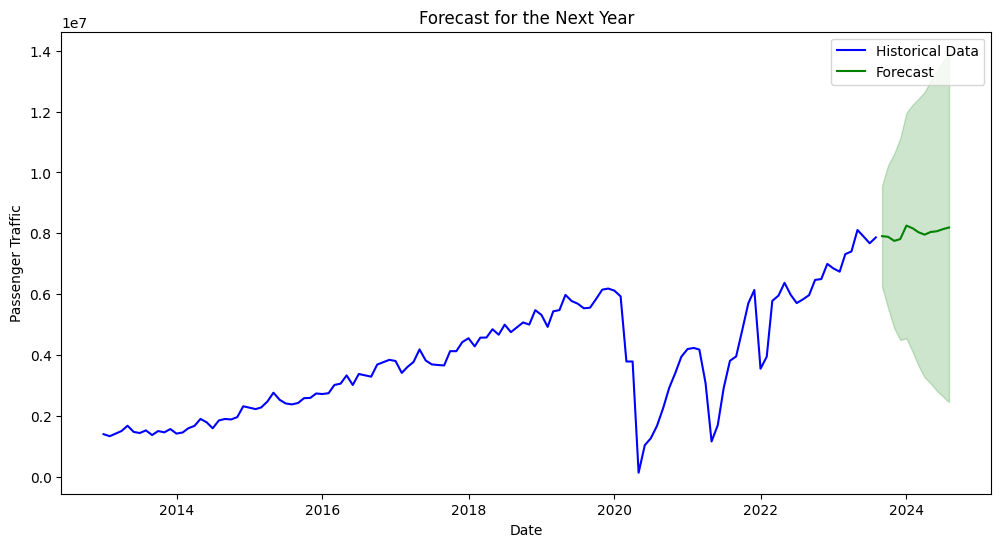

In [ ]:
train = df['PASSENGERS CARRIED']

# find the best fit model
auto_model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    trace=False
)

# obtain parameters of the model
best_order = auto_model.order
print(best_order)
best_seasonal_order = auto_model.seasonal_order
print(best_seasonal_order)

# Initialize and fit the SARIMAX model
model = sm.tsa.SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
results = model.fit(disp=False)

# Forecast for the next 12 months
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(train.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting the historical data, forecast, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PASSENGERS CARRIED'], label='Historical Data', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Passenger Traffic')
plt.title('Forecast for the Next Year')
plt.legend()
plt.show()

# Create a DataFrame for the forecasted results with "YEAR MONTH" format (e.g., "2024 JAN")
forecast_df = pd.DataFrame({
    'YEAR_MONTH': forecast_index.strftime('%Y %b').str.upper(),  # Format as "YEAR MONTH" in uppercase
    'PASSENGERS CARRIED': forecast_mean
})

# Write the predictions to a CSV file
forecast_df.to_csv('forecasted_passenger_traffic.csv', index=False)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.95)
_train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit the SARIMAX model
model = sm.tsa.SARIMAX(_train['PASSENGERS CARRIED'], order=best_order, seasonal_order=best_seasonal_order)
results = model.fit(disp=False)

# Forecast the test set
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Calculate evaluation metrics
mae = mean_absolute_error(test['PASSENGERS CARRIED'], forecast_mean)
mse = mean_squared_error(test['PASSENGERS CARRIED'], forecast_mean)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test['PASSENGERS CARRIED'] - forecast_mean) / test['PASSENGERS CARRIED'])) * 100

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Evaluation Metrics:
MAE: 390961.99430297356
MSE: 211096932697.08334
RMSE: 459452.862323311
MAPE: 5.042184550442835%
